# Artificial Intelligence for Timing Attacks

In this project, we compare two different algorithms to exploit a vulnerability that is common in
password validation methods.

In cryptography, a timing attack is a side-channel attack in which the attacker attempts to
compromise a cryptosystem by analyzing the time taken to execute cryptographic algorithms. Every
logical operation in a computer takes time to execute, and the time can differ based on the input;
with precise measurements of the time for each operation, an attacker can work backwards to the
input. Finding secrets through timing information may be significantly easier than using
cryptanalysis of known plaintext, ciphertext pairs. Sometimes timing information is combined with
cryptanalysis to increase the rate of information leakage.

Password validation method are often found to be vulnerable to these kind of attacks, and
vulnerabilities have been found in different projects and products, for example: the CVE-2021-38153
vulnerability reported in the Apache Kafka open source project, and the TPM-Fail vulnerability in
some of the Trusted Platform Modules implementations available in different hardware platforms.

This proof-of-concept uses three different methods to attack a vulnerable password validation
method. First, a traditional brute force approach is used, that explores the entire search space for
the key. Second, we use a Genetic Programming approach that use the timing information from the
vulnerable password validation method to find the solution. Third, we exploit the timing
vulnerability with a Metaheuristic Algorithm (Particle Swarm Optimization).

## References

1. [Timing Attack](https://en.wikipedia.org/wiki/Timing_attack)
2. [Side-Channel Attack](https://en.wikipedia.org/wiki/Side-channel_attack)
3. [CVE-2021-38153 Timing attack vulnerability for Apache Kafka Connect and Clients](https://cve.mitre.org/cgi-bin/cvename.cgi?name=CVE-2021-38153)
4. [TPM-FAIL: TPM meets Timing and Lattice Attacks](https://arxiv.org/abs/1911.05673)
5. [Genetic Programming](https://en.wikipedia.org/wiki/Genetic_programming)
6. [Metaheuristic](https://en.wikipedia.org/wiki/Metaheuristic)
7. [Particle Swarm Optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization)

In [ ]:
%load_ext autoreload
%autoreload 2

## Vulnerable Password Validation Method

The vulnerable password validation method is implemented in [auth.py](./auth.py). The problem in
that implementation is that the method takes a variable amount of time, depending on how *bad* the
password candidate is:

1. If the length of the password candidate doesn't match the length of the actual password, the
   method returns immediately.
2. When the length of the password candidate matches, it then do a sequential validation of both
   password, position by position. The return is faster when the initial characters of the passwords
   doesn't match
3. When the password match, the method takes the maximum amount of time

We can see this behavior by measuring the time in nanoseconds taken by the `validate` method to
return an answer. In the cell below, we plot the time taken to execute the validate function
depending the number of characters in the candidate password that matches the actual password
("5555555555" in this case):

Text(0, 0.5, 'Nanoseconds Taken To Compute')

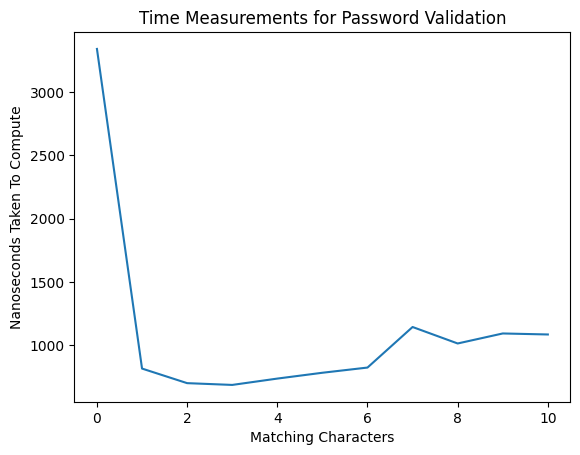

In [7]:
import time

from matplotlib import pyplot as plt

from auth import validate

candidates = [
    "0000000000",
    "5000000000",
    "5500000000",
    "5550000000",
    "5555000000",
    "5555500000",
    "5555550000",
    "5555555000",
    "5555555500",
    "5555555550",
    "5555555555",
]

nanoseconds = []

for i, candidate in enumerate(candidates):
    start = time.time_ns()
    validate(candidate)
    end = time.time_ns()
    nanoseconds.append(end - start)

plt.plot(nanoseconds)
plt.title("Time Measurements for Password Validation")
plt.xlabel("Matching Characters")
plt.ylabel("Nanoseconds")

We can see in the plot above that taking a single time measurement does not provide a good hint to
craft a Timing Attack. In our second version, we use the median time taken (in nanoseconds) of ten
executions of the `validate` method in a single password candidate. And here, the timing component
becomes evident:

Text(0, 0.5, 'Nanoseconds Taken To Compute')

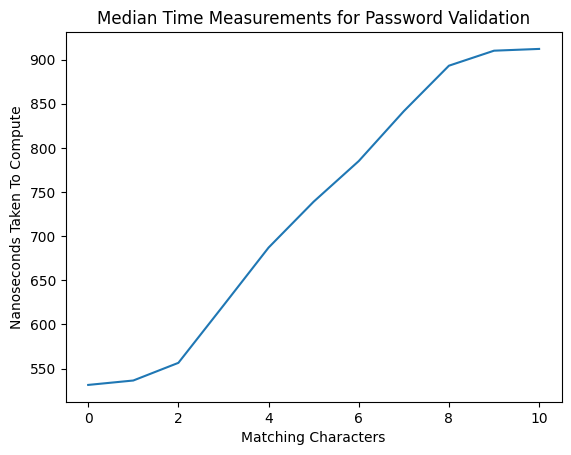

In [9]:
import statistics
import time

from matplotlib import pyplot as plt

from auth import validate

candidates = [
    "0000000000",
    "5000000000",
    "5500000000",
    "5550000000",
    "5555000000",
    "5555500000",
    "5555550000",
    "5555555000",
    "5555555500",
    "5555555550",
    "5555555555",
]

nanoseconds = [0 for _ in range(len(candidates))]

for i, candidate in enumerate(candidates):
    iterations = 10
    results = []
    for j in range(iterations):
        start = time.time_ns()
        validate(candidate)
        end = time.time_ns()
        results.append(end - start)
    nanoseconds[i] = statistics.median(results)

plt.plot(nanoseconds)
plt.title("Median Time Measurements for Password Validation")
plt.xlabel("Matching Characters")
plt.ylabel("Nanoseconds")

## Brute Force Implementation

The brute force implementation consist on exploring the entire search space for the right password,
without using any hint to improve the search. The search space in this case is 10^10, given by the
password length of 10 characters, and 10 available digits available as options.

The brute force implementation search sequentially, starting at "0000000001", and finishing at
"9999999999". To make a *fair* comparison with the other methods, we compute the time taken by the
brute force implementation to find a password that is approximately in the middle of the search
space ("5555555555" in this case).

The brute force implementation is available at [bf.py](./bf.py):

In [45]:
from bf import main

args = {
    "NUMBER_ITERATIONS": 0,
    "BRAKE_ON_SOLUTION": True,
}

%time main(args=args)

Solution = 5555555555
CPU times: user 56min 42s, sys: 9.26 ms, total: 56min 42s
Wall time: 56min 43s


As we can see in the metrics printed above, the brute force implementation takes approximately 57
minutes to explore the first half of the search space. This metric will vary depending on the
hardware used to execute the brute force implementation, but here where are providing it as a
comparison point with the other implementations. Also, the brute force implementation doesn't take
advantage of multiprocessing or multithreading, that could help improve this time.

## Genetic Algorithm Implementation

The GA implementation use the median time taken by the password validation method to process a given
candidate password. This value is used as the fitness score for a given member of the population.
The initial population is generated at random, their fitness scores is calculated, and then pair of
parents for the next generation are selected with a probability proportional to their fitness
scores. With the parents pairs selected, a crossover operation is executed to generate the members
of the new generation. Finally, a mutation operation is executed in the next generation.

Once we have the next generation, the algorithm is repeated until it finds a solution (or it reaches
a fixed number of iterations, to prevent going on forever).

The Genetic Algorithm implementation is available at [ga.py](./ga.py)

The following cell runs a Genetic Algorithm to execute a timing attack on the weak password
validation function:

Initial Population

Member 8948321691 Fitness 538.5
Member 8237827375 Fitness 558.5
Member 2768100420 Fitness 538.0
Member 3991755843 Fitness 536.5
Member 3911261414 Fitness 537.0
Member 9456364432 Fitness 524.0
Member 4877917568 Fitness 512.5
Member 8266818657 Fitness 519.5
Member 0849086428 Fitness 526.0
Member 5859224552 Fitness 538.0
Member 1042714804 Fitness 479.0
Member 9358443185 Fitness 617.0
Member 9832307085 Fitness 456.0
Member 6894439659 Fitness 457.5
Member 2805364484 Fitness 458.5
Member 6180415937 Fitness 458.5
Member 7799086187 Fitness 458.0
Member 9965824123 Fitness 460.0
Member 2605712568 Fitness 456.5
Member 5134761840 Fitness 538.0
Member 7472324703 Fitness 467.5
Member 3135200217 Fitness 459.5
Member 1267590089 Fitness 458.5
Member 1420989908 Fitness 456.5
Member 0747713721 Fitness 455.5
Member 5735990504 Fitness 537.5
Member 7238666152 Fitness 459.0
Member 6198871294 Fitness 457.5
Member 5842398952 Fitness 535.5
Member 9567595033 Fitness 459.5
Member 9450460831 Fi

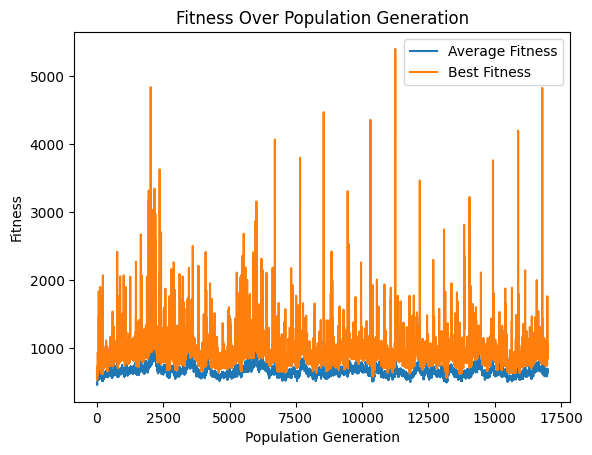

CPU times: user 40.1 s, sys: 220 ms, total: 40.3 s
Wall time: 40.1 s


In [46]:
from ga import main

args = {
    "POPULATION_SIZE": 100,
    "NUMBER_ITERATIONS": 60000,
    "MUTATION_PCT": 0.5,
    "BRAKE_ON_SOLUTION": True,
    "OUTPUT": "ga",
}

%time main(args=args)

We can see in the results above that the GA implementation took 40 seconds to find the actual
password ("5555555555" in this case). In the output, we can see a list of the initial population
members, and the final population members in the generation where the password was found. In the
plot, we can see the average fitness score and best fitness score per population generation. Again,
these metrics will vary depending on the hardware used to execute the genetic algorithm
implementation, but compared with the brute force implementation, there is a great improvement.
Also, the genetic algorithm implementation doesn't take advantage of multiprocessing or
multithreading, that could help improve this time.